In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from logger import logger
from tqdm import tqdm

dataset_name = 'MNIST'
batch_size = 128
shuffle = True

logger.info(f"Loading dataset: {dataset_name}")
dataset = getattr(datasets, dataset_name)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

logger.info(f"Setting up train data loader...")
train_dataset = dataset(root='./data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

logger.info(f"Setting up test data loader...")
test_dataset = dataset(root='./data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dshape = train_dataset[0][0].shape
logger.info(f"Data shape: {dshape}")

2024-04-05 12:13:21,892 - ModelRunner - INFO - Loading dataset: MNIST
2024-04-05 12:13:21,893 - ModelRunner - INFO - Setting up train data loader...
2024-04-05 12:13:21,918 - ModelRunner - INFO - Setting up test data loader...
2024-04-05 12:13:21,934 - ModelRunner - INFO - Data shape: torch.Size([1, 28, 28])


In [2]:
import torch

def gaussian_kernel(x, y, sigma=1.0):
    """
    Computes the Gaussian kernel matrix between two sets of vectors x and y.
    :param x: Tensor of shape (batch_size, feature_dim)
    :param y: Tensor of shape (batch_size, feature_dim)
    :param sigma: Float, bandwidth parameter for the Gaussian kernel
    :return: Tensor of shape (batch_size, batch_size) containing the kernel matrix
    """
    # Compute pairwise squared Euclidean distances
    distances = torch.cdist(x, y, p=2)**2
    
    # Compute Gaussian kernel matrix
    kernel_matrix = torch.exp(-distances / (2 * sigma**2))
    
    return kernel_matrix


In [3]:
from wae_mmd import WAE_MMD

device = 'cpu'

in_channels = dshape[0]
out_channels = 64
z_dim = 8
lmbda = 1
kernel = gaussian_kernel

wae_mmd = WAE_MMD(in_channels, out_channels, z_dim, lmbda, kernel, device)

In [38]:
encoder_optimizer = torch.optim.Adam(wae_mmd.encoder.parameters(), lr=0.001)
decoder_optimizer = torch.optim.Adam(wae_mmd.decoder.parameters(), lr=0.001)
latent_discriminator_optimizer = torch.optim.Adam(wae_mmd.latent_discriminator.parameters(), lr=0.001)

# Define training loop
num_batches = len(train_dataloader)
num_epochs = 100
total = num_epochs * num_batches

with tqdm(total=total, desc="Training") as pbar:
    iteration = 0
    for epoch in range(num_epochs):
        for batch_idx, (X, _) in enumerate(train_dataloader):
            X = X.to(device)

            reconstruction_loss, mmd_loss, latent_discriminator_loss = wae_mmd.train_step(X, encoder_optimizer, decoder_optimizer, latent_discriminator_optimizer)
           
            pbar.update(1)
            pbar.set_postfix({
                'Epoch': f'{epoch+1}/{num_epochs}',
                'Batch': f'{batch_idx+1}/{num_batches}',
                'Reconstruction': f'{reconstruction_loss:.4f}',
                'MMD': f'{mmd_loss:.4f}',
                'Latent Discriminator': f'{latent_discriminator_loss:.4f}'
                })
            
            iteration += 1
            if iteration == 1:
                torch.save(wae_mmd.state_dict(), f'wae_mmd_{iteration}.pt')
            if iteration % 5000 == 0:
                # Save model
                torch.save(wae_mmd.state_dict(), f'wae_mmd_{iteration}.pt')


Training:   0%|          | 0/46900 [00:00<?, ?it/s]

Training: 100%|██████████| 46900/46900 [1:07:55<00:00, 11.51it/s, Epoch=100/100, Batch=469/469, Reconstruction=0.8689, MMD=0.0206, Latent Discriminator=0.8376]


In [12]:
from torchvision.models import inception_v3, Inception_V3_Weights
import numpy as np
from scipy.stats import entropy
import torch
import torch.nn.functional as F
from scipy.linalg import sqrtm

wae_mmd = WAE_MMD(in_channels, out_channels, z_dim, lmbda, kernel, device)
wae_mmd.load_state_dict(torch.load('wae_mmd_10000.pt'))

# Load pretrained InceptionV3 model
inception_model = inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=False)

def extract_features(sample):
    # Resize input sample to match minimum input size required by InceptionV3 (299x299)
    resized_sample = F.interpolate(sample, size=(299, 299), mode='bilinear', align_corners=False)
    # Extract features using the InceptionV3 model
    with torch.no_grad():
        features = inception_model(resized_sample)
    return features

def torch_cov(m, rowvar=False):
    # If input tensor has only one dimension, return zero matrix
    if m.dim() <= 1:
        return torch.zeros((m.size(0), m.size(0)), dtype=m.dtype, device=m.device)

    # If rowvar is False, transpose input tensor
    if not rowvar:
        m = m.t()

    # Subtract the mean along the columns
    m -= torch.mean(m, dim=1, keepdim=True)

    # Calculate covariance matrix
    fact = 1.0 / (m.size(1) - 1)
    m_t = m.t()
    cov_matrix = fact * m.matmul(m_t).squeeze()
    return cov_matrix

def calculate_fid(X_3d_features, X_hat_3d_features):
    X_3d_mu, X_3d_sigma = torch.mean(X_3d_features.logits, dim=0), torch_cov(X_3d_features.logits, rowvar=False)
    X_hat_3d_mu, X_hat_3d_sigma = torch.mean(X_hat_3d_features.logits, dim=0), torch_cov(X_hat_3d_features.logits, rowvar=False)

    # Compute the squared Frobenius norm between two covariance matrices
    covmean = sqrtm(X_3d_sigma @ X_hat_3d_sigma)
    
    # Ensure that covmean is real
    if not np.isfinite(covmean).all():
        cov_xx = torch.matmul(X_3d_sigma, X_3d_sigma)
        cov_yy = torch.matmul(X_hat_3d_sigma, X_hat_3d_sigma)
        covmean = sqrtm(cov_xx * cov_yy)
    
    # Compute the FID
    fid = torch.norm(X_3d_mu - X_hat_3d_mu) ** 2 + torch.trace(X_3d_sigma + X_hat_3d_sigma - 2 * covmean)
    return fid.item()

def inception_score(features):
    # Get logits from InceptionOutputs object
    logits = features.logits
    # Compute softmax probabilities for each generated sample
    probs = torch.nn.functional.softmax(logits, dim=1)
    # Detach tensor from the computation graph and convert to NumPy array
    probs_numpy = probs.detach().cpu().numpy()
    # Calculate entropy for each sample
    entropy_per_sample = entropy(probs_numpy, axis=1)
    # Compute average softmax prediction confidence
    avg_confidence = np.mean(np.max(probs_numpy, axis=1))
    # Combine quality and diversity
    inception_score = np.exp(avg_confidence) * np.mean(entropy_per_sample)
    return inception_score

def generate_samples(num_samples):
    # 1. Sample latent vectors from a Gaussian distribution
    z_samples = torch.randn(num_samples, z_dim)
    
    # 2. Feed the sampled latent vectors through the decoder
    with torch.no_grad():
        generated_samples = wae_mmd.decoder(z_samples)
    
    return generated_samples

def d1_to_d3_images(images):
    return images.repeat(1, 3, 1, 1)

# Example usage
X_hat = generate_samples(batch_size)
X_hat_3d = d1_to_d3_images(X_hat)
X_hat_3d_features = extract_features(X_hat_3d)
X_hat_3d_is_score = inception_score(X_hat_3d_features)

X = next(iter(test_dataloader))[0].to(device)
X_3d = d1_to_d3_images(X)
X_3d_features = extract_features(X_3d)

print(f"Inception Score: {X_hat_3d_is_score:.2f}")

fid_score = calculate_fid(X_3d_features, X_hat_3d_features)
print(f"FID Score: {fid_score:.2f}")
# for batch_idx, (X, _) in enumerate(test_dataloader):
#     X = X.to(device)
#     X_3 = X.repeat(1, 3, 1, 1)
#     features = extract_features(X_3)
#     break


Inception Score: 6.49
FID Score: 724.05-0.20j


In [22]:
from torchvision.models import inception_v3
import numpy as np
from scipy.stats import entropy
import torch
import torch.nn.functional as F
from scipy.linalg import sqrtm

# Define your WAE-MMD model (WAE_MMD class definition is missing)
# Example: 
wae_mmd = WAE_MMD(in_channels, out_channels, z_dim, lmbda, kernel, device)
wae_mmd.load_state_dict(torch.load('wae_mmd_10000.pt'))

# Load pretrained InceptionV3 model
inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model.eval()

def extract_features(sample):
    # Resize input sample to match minimum input size required by InceptionV3 (299x299)
    resized_sample = F.interpolate(sample, size=(299, 299), mode='bilinear', align_corners=False)
    # Extract features using the InceptionV3 model
    with torch.no_grad():
        features = inception_model(resized_sample)
    return features

def torch_cov(m, rowvar=False):
    # If input tensor has only one dimension, return zero matrix
    if m.dim() <= 1:
        return torch.zeros((m.size(0), m.size(0)), dtype=m.dtype, device=m.device)

    # If rowvar is False, transpose input tensor
    if not rowvar:
        m = m.t()

    # Subtract the mean along the columns
    m -= torch.mean(m, dim=1, keepdim=True)

    # Calculate covariance matrix
    fact = 1.0 / (m.size(1) - 1)
    m_t = m.t()
    cov_matrix = fact * m.matmul(m_t).squeeze()
    return cov_matrix

def calculate_fid(X_3d_features, X_hat_3d_features):
    X_3d_mu, X_3d_sigma = torch.mean(X_3d_features, dim=0), torch_cov(X_3d_features, rowvar=False)
    X_hat_3d_mu, X_hat_3d_sigma = torch.mean(X_hat_3d_features, dim=0), torch_cov(X_hat_3d_features, rowvar=False)

    # Compute the squared Frobenius norm between two covariance matrices
    covmean = sqrtm(X_3d_sigma @ X_hat_3d_sigma)
    
    # Ensure that covmean is real
    if not np.isfinite(covmean).all():
        cov_xx = torch.matmul(X_3d_sigma, X_3d_sigma)
        cov_yy = torch.matmul(X_hat_3d_sigma, X_hat_3d_sigma)
        covmean = sqrtm(cov_xx * cov_yy)
    
    # Compute the FID
    fid = torch.norm(X_3d_mu - X_hat_3d_mu) ** 2 + torch.trace(X_3d_sigma + X_hat_3d_sigma - 2 * covmean)
    return fid.item()

def inception_score(features):
    # Get logits from InceptionOutputs object
    logits = features
    # Compute softmax probabilities for each generated sample
    probs = torch.nn.functional.softmax(logits, dim=1)
    # Detach tensor from the computation graph and convert to NumPy array
    probs_numpy = probs.detach().cpu().numpy()
    # Calculate entropy for each sample
    entropy_per_sample = entropy(probs_numpy, axis=1)
    # Compute average softmax prediction confidence
    avg_confidence = np.mean(np.max(probs_numpy, axis=1))
    # Combine quality and diversity
    inception_score = np.exp(avg_confidence) * np.mean(entropy_per_sample)
    return inception_score

def generate_samples(num_samples):
    # 1. Sample latent vectors from a Gaussian distribution
    z_samples = torch.randn(num_samples, z_dim)
    
    # 2. Feed the sampled latent vectors through the decoder
    with torch.no_grad():
        generated_samples = wae_mmd.decoder(z_samples)
    
    return generated_samples

def d1_to_d3_images(images):
    return images.repeat(1, 3, 1, 1)


# Generate samples
X_hat = generate_samples(batch_size)
X_hat_3d = d1_to_d3_images(X_hat)

# Extract features
X_hat_3d_features = extract_features(X_hat_3d)

# Calculate Inception Score
X_hat_3d_is_score = inception_score(X_hat_3d_features)
print(f"Inception Score: {X_hat_3d_is_score:.2f}")



Inception Score: 5.35


In [ ]:

def torch_cov(m, rowvar=False):
    # If input tensor has only one dimension, return zero matrix
    if m.dim() <= 1:
        return torch.zeros((m.size(0), m.size(0)), dtype=m.dtype, device=m.device)

    # If rowvar is False, transpose input tensor
    if not rowvar:
        m = m.t()

    # Subtract the mean along the columns
    m -= torch.mean(m, dim=1, keepdim=True)

    # Calculate covariance matrix
    fact = 1.0 / (m.size(1) - 1)
    m_t = m.t()
    cov_matrix = fact * m.matmul(m_t).squeeze()
    return cov_matrix

# def calculate_fid(X_3d_features, X_hat_3d_features):
#     X_3d_mu, X_3d_sigma = torch.mean(X_3d_features, dim=0), torch_cov(X_3d_features, rowvar=False)
#     X_hat_3d_mu, X_hat_3d_sigma = torch.mean(X_hat_3d_features, dim=0), torch_cov(X_hat_3d_features, rowvar=False)

#     # Compute the squared Frobenius norm between two covariance matrices
#     covmean = sqrtm(X_3d_sigma @ X_hat_3d_sigma)
    
#     # Ensure that covmean is real
#     if not np.isfinite(covmean).all():
#         cov_xx = torch.matmul(X_3d_sigma, X_3d_sigma)
#         cov_yy = torch.matmul(X_hat_3d_sigma, X_hat_3d_sigma)
#         covmean = sqrtm(cov_xx * cov_yy)
    
#     # Compute the FID
#     fid = torch.norm(X_3d_mu - X_hat_3d_mu) ** 2 + torch.trace(X_3d_sigma + X_hat_3d_sigma - 2 * covmean)
#     return fid.item()

# You need real data (X_3d_features) to calculate FID
X = next(iter(test_dataloader))[0].to(device)
X_3d = d1_to_d3_images(X)
X_3d_features = extract_features(X_3d)
# fid_score = calculate_fid(X_3d_features, X_hat_3d_features)


from ignite.engine import Engine
from ignite.metrics import FID
def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

metric = FID(feature_extractor=inception_model)
metric.attach(default_evaluator, "fid")
y_true = torch.ones(10, 4)
y_pred = torch.ones(10, 4)
state = default_evaluator.run([[y_pred, y_true]])
print(state.metrics["fid"])

# metric = FID(feature_extractor=inception_model, output_transform=lambda x: (X_3d, X_hat_3d))
# metric.attach(default_evaluator, "fid")
# # y_true = torch.ones(10, 4)
# # y_pred = torch.ones(10, 4)
# # state = default_evaluator.run([[y_pred, y_true]])
# # print(state.metrics["fid"])

In [34]:
from ignite.engine import Engine
from ignite.metrics import FID
def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

metric = FID()
metric.attach(default_evaluator, "fid")
X_hat_3d_299 = F.interpolate(X_hat_3d, size=(299, 299), mode='bilinear', align_corners=False)
X_3d_299 = F.interpolate(X_3d, size=(299, 299), mode='bilinear', align_corners=False)
state = default_evaluator.run([[X_hat_3d_299, X_3d_299]])
print(state.metrics["fid"])


Engine run is terminating due to exception: Imaginary component 2.810176541112624e+42


ValueError: Imaginary component 2.810176541112624e+42

In [75]:
import torch
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from scipy.linalg import sqrtm
import numpy as np
import torch.nn.functional as F

# Generate samples
def generate_samples(num_samples):
    # 1. Sample latent vectors from a Gaussian distribution
    z_samples = torch.randn(num_samples, z_dim)
    
    # 2. Feed the sampled latent vectors through the decoder
    with torch.no_grad():
        generated_samples = wae_mmd_pt.decoder(z_samples)
    
    return generated_samples

def extract_features(images, batch_size=100):
    features = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        resized_batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
        batch_rgb = torch.cat((resized_batch, resized_batch, resized_batch), dim=1)
        # Pass the RGB images to the Inception model
        outputs = incepv3_pt(batch_rgb)
        # Extract desired features from the InceptionOutputs object
        # For example, you can use outputs.logits for classification features
        features.append(outputs.logits)  # Adjust this line based on the desired features
    return torch.cat(features, dim=0)


# PyTorch implementation of covariance calculation (similar to numpy)
def torch_cov(m, rowvar=False):
    if m.dim() <= 1:
        return torch.zeros((m.size(0), m.size(0)), dtype=m.dtype, device=m.device)
    if not rowvar and m.size(0) != 1:
        m = m.t()
    # Calculate covariance matrix
    fact = 1.0 / (m.size(1) - 1)
    m -= torch.mean(m, dim=1, keepdim=True)
    mt = m.t()
    return fact * m.matmul(mt).squeeze()


# Load WAE-MMD model
wae_mmd_pt = wae_mmd
wae_mmd_pt.load_state_dict(torch.load('wae_mmd_22000.pt'))

# Load Inception model
incepv3_pt = inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=False)

# Generate data
generated_data = generate_samples(len(test_dataset))

# Preprocess synthetic and real images for InceptionV3
# synthetic_features = extract_features(generated_data)
x_features = []
for x, _ in test_dataloader:
    x = x.to(device)
    X_hat_3d_features = extract_features(x)
    x_features.append(X_hat_3d_features)
X_3d_features = torch.cat(x_features, dim=0)

# # Compute mean and covariance
# mu_real, sigma_real = torch.mean(real_features, dim=0), torch_cov(real_features, rowvar=False)
# mu_synthetic, sigma_synthetic = torch.mean(synthetic_features, dim=0), torch_cov(synthetic_features, rowvar=False)





# synthetic_images_tensor = torch.from_numpy(synthetic_images).float().cuda()
# synthetic_features = extract_features(synthetic_images_tensor)

: 

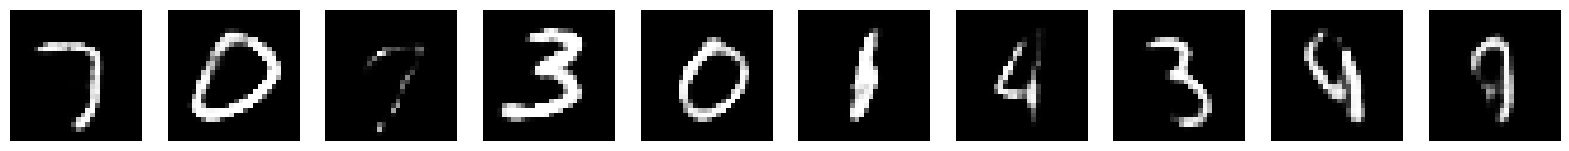

In [39]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming wae_mmd is your trained WAE model
def generate_samples(num_samples):
    # 1. Sample latent vectors from a Gaussian distribution
    z_samples = torch.randn(num_samples, wae_mmd.z_dim)
    
    # 2. Feed the sampled latent vectors through the decoder
    with torch.no_grad():
        generated_samples = wae_mmd.decoder(z_samples)
    
    return generated_samples

# Generate 10 samples
num_samples = 10
X_hat = generate_samples(num_samples)

# Plot the generated samples
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i in range(num_samples):
    sample = X_hat[i].squeeze().numpy()  # Convert to numpy array
    axes[i].imshow(sample, cmap='gray')
    axes[i].axis('off')

plt.show()


KeyboardInterrupt: 

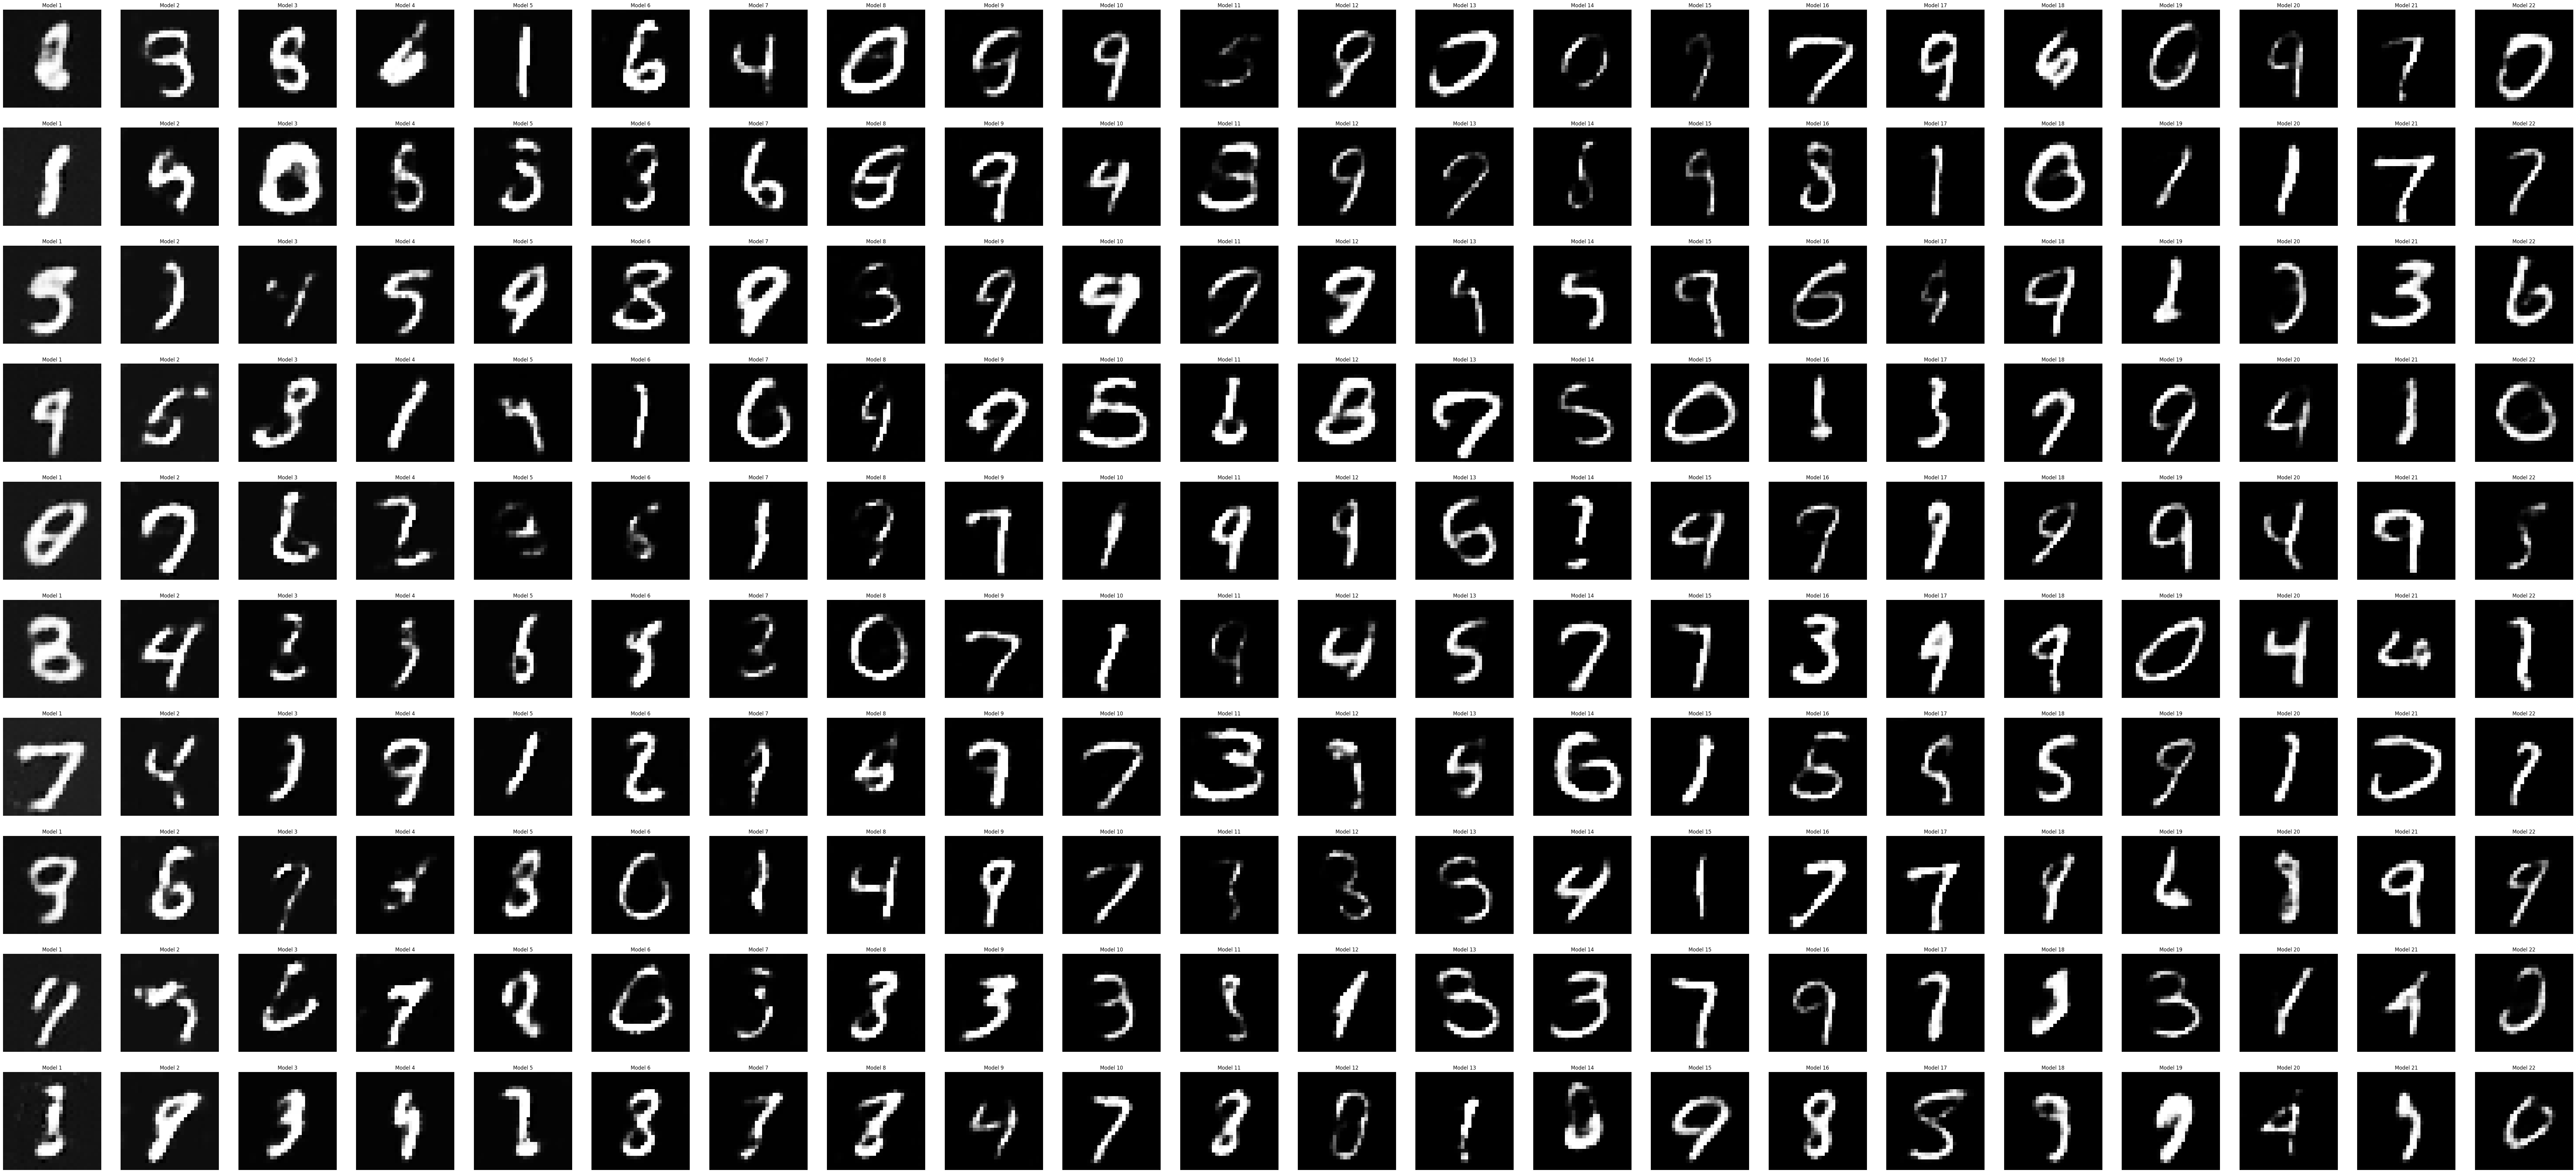

In [5]:
import torch
import matplotlib.pyplot as plt

# Assuming wae_mmd is your trained WAE model
def generate_samples(model_path, num_samples, model_name):
    wae_mmd.load_state_dict(torch.load(model_path))
    
    # Sample latent vectors from a Gaussian distribution
    z_samples = torch.randn(num_samples, wae_mmd.z_dim).to(device)
    
    # Feed the sampled latent vectors through the decoder
    with torch.no_grad():
        generated_samples = wae_mmd.decoder(z_samples)
    
    return generated_samples, model_name

# Generate samples and plot them for each model
def plot_generated_samples(model_paths, num_samples):
    num_models = len(model_paths)
    
    fig, axes = plt.subplots(num_samples, num_models, figsize=(5*num_models, 5*num_samples))
    
    for j, model_path in enumerate(model_paths):
        generated_samples, model_name = generate_samples(model_path, num_samples, f"Model {j+1}")
        
        for i in range(num_samples):
            sample = generated_samples[i].squeeze().numpy()  # Convert to numpy array
            axes[i, j].imshow(sample, cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(model_name)  # Set title as model name
    
    plt.tight_layout()
    plt.show()

# List of model paths saved at each 1000th batch
model_paths = [f'wae_mmd_{i}000.pt' for i in range(1, 23)]

# Generate and plot samples for each model
num_samples = 10
plot_generated_samples(model_paths, num_samples)


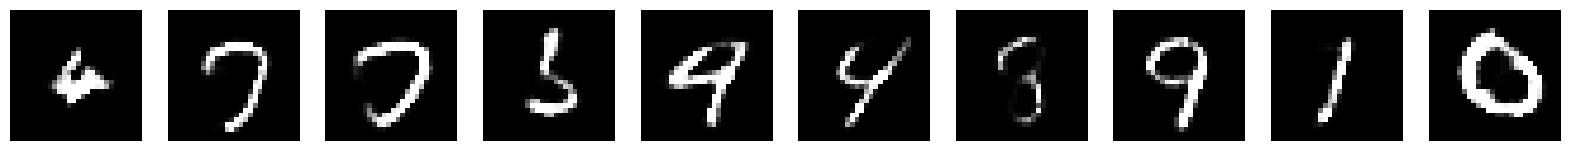

In [43]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming gen_model is your trained WAE model
def generate_samples(gen_model, num_samples):
    # 1. Sample latent vectors from a Gaussian distribution
    z_samples = torch.randn(num_samples, gen_model.z_dim)
    
    # 2. Feed the sampled latent vectors through the decoder
    with torch.no_grad():
        generated_samples = gen_model.decoder(z_samples)
    
    return generated_samples

# Generate 10 samples
num_samples = 10
gen_model = WAE_MMD(in_channels, out_channels, z_dim, lmbda, kernel, device)
gen_model.load_state_dict(torch.load('wae_mmd_10000.pt'))
X_hat = generate_samples(gen_model, num_samples)

# Plot the generated samples
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i in range(num_samples):
    sample = X_hat[i].squeeze().numpy()  # Convert to numpy array
    axes[i].imshow(sample, cmap='gray')
    axes[i].axis('off')

plt.show()


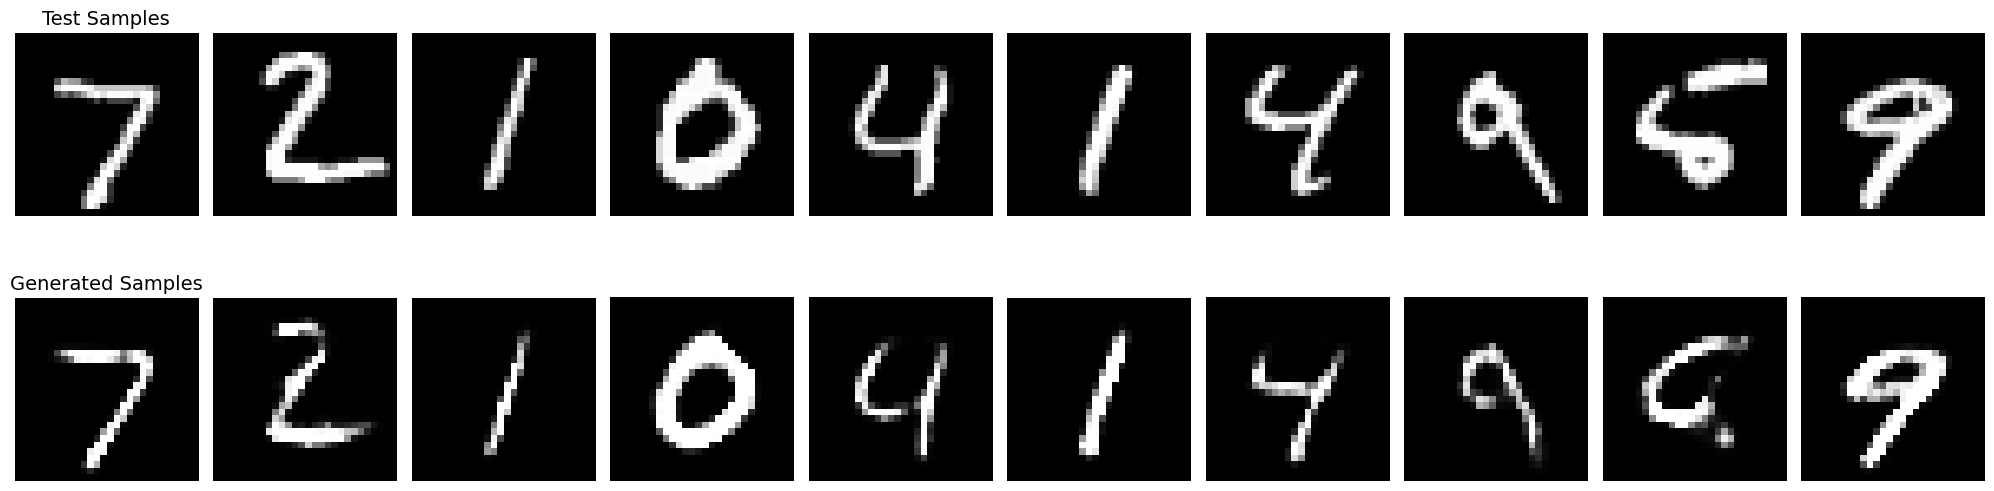

In [42]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming gen_model is your trained WAE model
def reconstruct_samples(gen_model, samples):
    # 1. Sample latent vectors from a Gaussian distribution
    # z_samples = torch.randn(num_samples, gen_model.z_dim)
    z_mean, z_logvar = gen_model.encoder(samples)
    z_samples = gen_model.reparameterize(z_mean, z_logvar)
    
    # 2. Feed the sampled latent vectors through the decoder
    with torch.no_grad():
        generated_samples = gen_model.decoder(z_samples)
    
    return generated_samples

# Generate 10 samples
num_samples = 10
gen_model = WAE_MMD(in_channels, out_channels, z_dim, lmbda, kernel, device)
gen_model.load_state_dict(torch.load('wae_mmd_10000.pt'))
test_samples = next(iter(test_dataloader))[0].to(device)
reconstructed_samples = reconstruct_samples(gen_model, test_samples)

fig, axes = plt.subplots(2, num_samples, figsize=(20, 6))
axes[0, 0].set_title('Test Samples', fontsize=14)
axes[1, 0].set_title('Reconstructed Samples', fontsize=14)

for i in range(num_samples):
    # Plot test sample
    axes[0, i].imshow(test_samples[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    
    # Plot generated sample
    axes[1, i].imshow(reconstructed_samples[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()